## <span style="color : yellow;"> MLP Assignemnt </span>

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import seaborn as sns

### Load and Visualize Dataset

In [9]:
def dataset_visulaizer(datasets, num_img=6):
    fig, axes = plt.subplots(1, num_img, figsize=(12, 4))

    for i in range(num_img):
         idx = np.random.randint(0, len(datasets))
         image, label = datasets[idx]

         axes[i].imshow(image.squeeze(), cmap='gray')
         axes[i].set_title(f'Label: {label}')
         axes[i].axis('off')
    plt.show()

In [10]:
# Function to load MNIST dataset using torchvision
def load_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    # Download and load training data
    train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Download and load testing data
    test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    dataset_visulaizer(train_data)
    dataset_visulaizer(test_data)


    return train_loader, test_loader

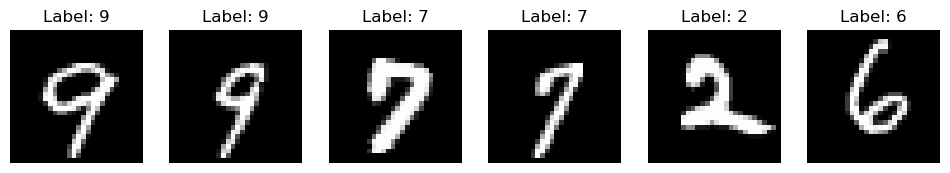

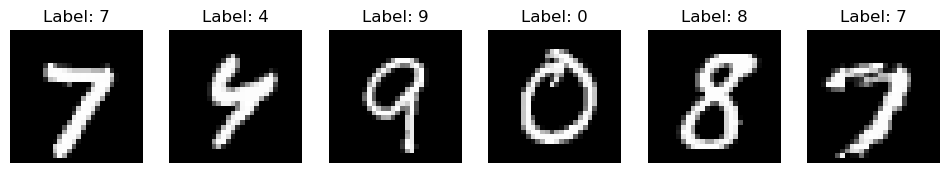

(<torch.utils.data.dataloader.DataLoader at 0x1debc1e3df0>,
 <torch.utils.data.dataloader.DataLoader at 0x1debc1bc8e0>)

In [11]:
load_data()

### Fucntion Definitions 

In [12]:
# Function for one-hot encoding labels
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [13]:
# Activation functions for hidden layers
def act_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def act_tanh(x):
    return np.tanh(x)

def act_relu(x):
    return np.maximum(0, x)


In [14]:
# Derivative of activation functions (used in backpropagation)
def deriv_sigmoid(x):
    return act_sigmoid(x) * (1 - act_sigmoid(x))

def deriv_tanh(x):
    return 1 - np.tanh(x) ** 2

def deriv_relu(x):
    return np.where(x > 0, 1, 0)

In [15]:
# Softmax for output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # numerical stability, otherwise having overflow 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [16]:
# Cross entropy loss
def loss_ce(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

In [17]:
# Glorot initialization
def init_glorot(shape):
    num_inputs, num_outputs = shape
    limit = np.sqrt(6 / (num_inputs + num_outputs))
    return np.random.uniform(-limit, limit, size=shape)

### Define MLP Model (Custom definitions)

In [18]:
# Model class for handling the forward pass and backward pass
class SimpleNN:
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn, activation_deriv):
        self.w1 = init_glorot((input_size, hidden_sizes[0]))
        self.b1 = np.zeros((1, hidden_sizes[0]))
        self.w2 = init_glorot((hidden_sizes[0], hidden_sizes[1]))
        self.b2 = np.zeros((1, hidden_sizes[1]))
        self.w3 = init_glorot((hidden_sizes[1], hidden_sizes[2]))
        self.b3 = np.zeros((1, hidden_sizes[2]))
        self.w_out = init_glorot((hidden_sizes[2], output_size))
        self.b_out = np.zeros((1, output_size))

        self.activation_fn = activation_fn
        self.activation_deriv = activation_deriv

    # Forward pass
    def forward(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.activation_fn(self.z1)

        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.activation_fn(self.z2)

        self.z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = self.activation_fn(self.z3)

        self.z_out = np.dot(self.a3, self.w_out) + self.b_out
        y_hat = softmax(self.z_out)
        return y_hat

    # Backward pass (for gradients)
    def backward(self, X, y_true, y_pred):
        m = y_true.shape[0]

        dz_out = (y_pred - y_true) / m
        dw_out = np.dot(self.a3.T, dz_out)
        db_out = np.sum(dz_out, axis=0, keepdims=True)

        dz3 = np.dot(dz_out, self.w_out.T) * self.activation_deriv(self.z3)
        dw3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)

        dz2 = np.dot(dz3, self.w3.T) * self.activation_deriv(self.z2)
        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.w2.T) * self.activation_deriv(self.z1)
        dw1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = [dw1, db1, dw2, db2, dw3, db3, dw_out, db_out]
        return grads

    # Update weights using gradient descent
    def update_weights(self, grads, lr):
        dw1, db1, dw2, db2, dw3, db3, dw_out, db_out = grads
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.w3 -= lr * dw3
        self.b3 -= lr * db3
        self.w_out -= lr * dw_out
        self.b_out -= lr * db_out

### Training Pipeline

In [20]:
def train_nn(nn_model, train_loader, lr=0.01, epochs=15, plot_every=200):
    train_losses = []
    iteration_losses = []
    iteration_count = 0

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.view(-1, 28 * 28).numpy()  # Flatten the input batch
            y_batch = one_hot_encode(y_batch.numpy())  # One-hot encode the labels

            # Forward pass
            y_pred = nn_model.forward(X_batch)

            # Compute loss
            loss = loss_ce(y_batch, y_pred)
            epoch_loss += loss

            # Backward pass and weight update
            grads = nn_model.backward(X_batch, y_batch, y_pred)
            nn_model.update_weights(grads, lr)

            iteration_count += 1

            # Every 200 iterations, record and print loss
            if iteration_count % plot_every == 0:
                avg_loss = epoch_loss / iteration_count
                iteration_losses.append(avg_loss)
                print(f'Iteration {iteration_count}, Loss: {avg_loss:.4f}')

        # Store the average loss for the epoch
        train_losses.append(epoch_loss / len(train_loader))

    # Plot losses every 200 iterations
    plt.plot(range(plot_every, plot_every * (len(iteration_losses) + 1), plot_every), iteration_losses)
    plt.xlabel(f"Iterations (every {plot_every})")
    plt.ylabel("Loss")
    plt.title("Training Loss per Iteration")
    plt.show()

    return train_losses


### Testing Pipeline

In [21]:
# Function to evaluate the model
def eval_nn(nn_model, test_loader):
    all_preds = []
    all_labels = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(-1, 28 * 28).numpy()
        y_pred = nn_model.forward(X_batch)
        predicted_labels = np.argmax(y_pred, axis=1)
        all_preds.extend(predicted_labels)
        all_labels.extend(y_batch.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, conf_matrix


### Plots and Compare

In [22]:
# Function to plot the training loss
def plot_loss(train_losses, title):
    plt.plot(train_losses)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


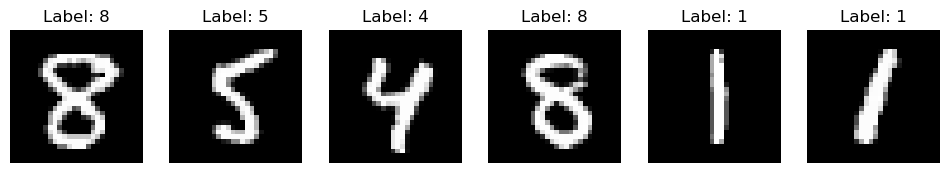

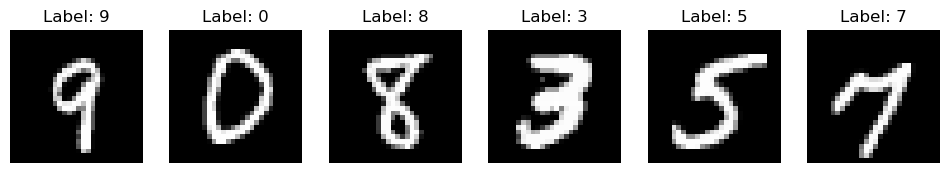

Training Sigmoid Model
Iteration 200, Loss: 2.3090
Iteration 400, Loss: 2.3006
Iteration 600, Loss: 2.2952
Iteration 800, Loss: 2.2907
Iteration 1000, Loss: 0.1404
Iteration 1200, Loss: 0.4933
Iteration 1400, Loss: 0.7438
Iteration 1600, Loss: 0.9301
Iteration 1800, Loss: 1.0735
Iteration 2000, Loss: 0.1362
Iteration 2200, Loss: 0.3217
Iteration 2400, Loss: 0.4740
Iteration 2600, Loss: 0.6004
Iteration 2800, Loss: 0.7053
Iteration 3000, Loss: 0.1252
Iteration 3200, Loss: 0.2391
Iteration 3400, Loss: 0.3353
Iteration 3600, Loss: 0.4161
Iteration 3800, Loss: 0.0212
Iteration 4000, Loss: 0.1002
Iteration 4200, Loss: 0.1675
Iteration 4400, Loss: 0.2247
Iteration 4600, Loss: 0.2738
Iteration 4800, Loss: 0.0285
Iteration 5000, Loss: 0.0758
Iteration 5200, Loss: 0.1167
Iteration 5400, Loss: 0.1524
Iteration 5600, Loss: 0.1837
Iteration 5800, Loss: 0.0289
Iteration 6000, Loss: 0.0593
Iteration 6200, Loss: 0.0863
Iteration 6400, Loss: 0.1103
Iteration 6600, Loss: 0.0042
Iteration 6800, Loss: 0.

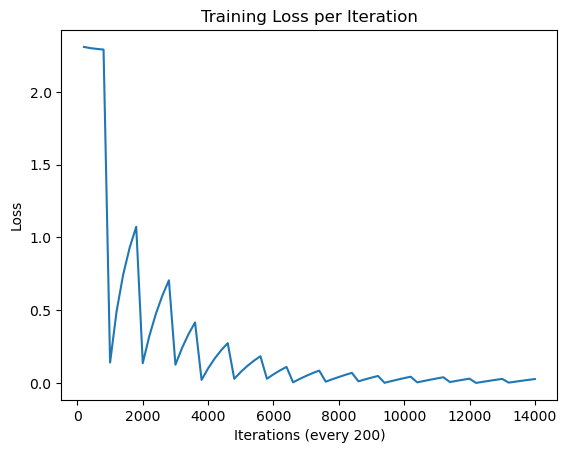

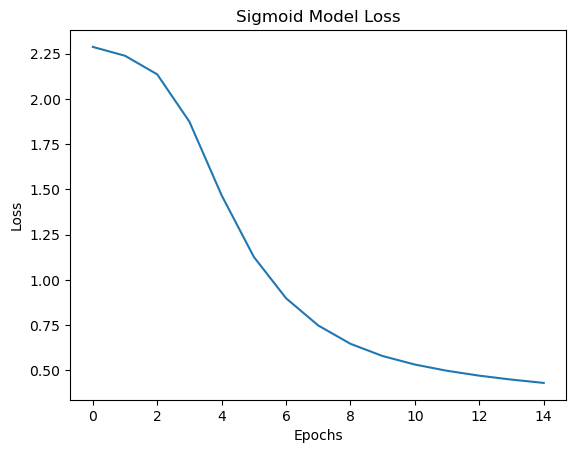

Sigmoid Accuracy: 0.8815
Confusion Matrix:
[[ 953    0    3    1    1   12    8    1    1    0]
 [   0 1102    1    6    0    2    3    1   19    1]
 [  15   11  896   21   22    3   20   14   28    2]
 [   3    4   27  861    0   48    2   24   32    9]
 [   1    8    7    0  880    2   11    0    6   67]
 [  13    3    9   64   17  710   28   11   23   14]
 [  22    5   10    0   15   25  879    0    2    0]
 [   4   18   23    2    6    0    0  929    4   42]
 [   5   17   12   33   23   50   18    8  784   24]
 [  14    7    4    8   90   10    0   49    6  821]]

Training Tanh Model
Iteration 200, Loss: 1.0056
Iteration 400, Loss: 0.7475
Iteration 600, Loss: 0.6253
Iteration 800, Loss: 0.5570
Iteration 1000, Loss: 0.0196
Iteration 1200, Loss: 0.0648
Iteration 1400, Loss: 0.0950
Iteration 1600, Loss: 0.1175
Iteration 1800, Loss: 0.1335
Iteration 2000, Loss: 0.0150
Iteration 2200, Loss: 0.0354
Iteration 2400, Loss: 0.0516
Iteration 2600, Loss: 0.0642
Iteration 2800, Loss: 0.0750
Ite

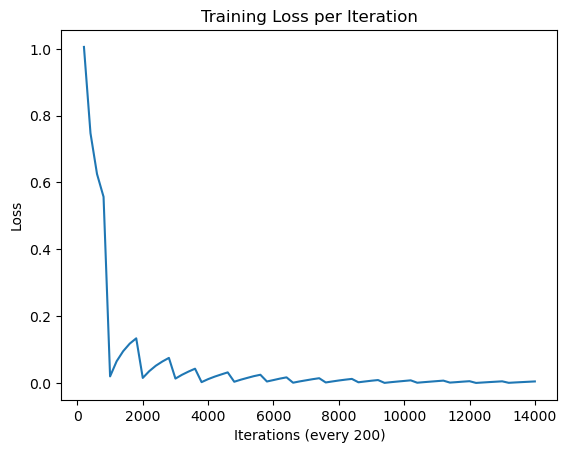

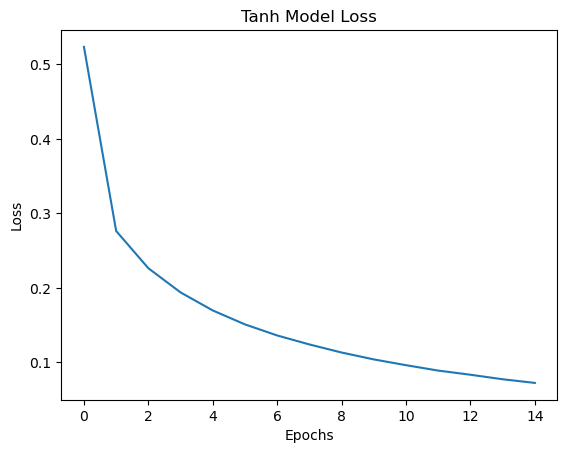

Tanh Accuracy: 0.9706
Confusion Matrix:
[[ 964    0    0    1    0    4    5    2    4    0]
 [   0 1124    3    1    0    1    3    1    2    0]
 [   7    2 1006    1    1    0    2    6    7    0]
 [   0    0    7  974    0    9    0    7   12    1]
 [   1    0    7    1  962    0    4    1    2    4]
 [   6    1    0    8    2  860    7    0    6    2]
 [   6    2    0    1    5    4  937    0    3    0]
 [   1    4   15    3    2    0    0  996    3    4]
 [   3    0    4    5    3    4    4    4  947    0]
 [   4    4    2    8   26    4    1   11   13  936]]

Training ReLU Model
Iteration 200, Loss: 1.0282
Iteration 400, Loss: 0.7462
Iteration 600, Loss: 0.6228
Iteration 800, Loss: 0.5509
Iteration 1000, Loss: 0.0182
Iteration 1200, Loss: 0.0616
Iteration 1400, Loss: 0.0909
Iteration 1600, Loss: 0.1110
Iteration 1800, Loss: 0.1263
Iteration 2000, Loss: 0.0147
Iteration 2200, Loss: 0.0337
Iteration 2400, Loss: 0.0474
Iteration 2600, Loss: 0.0596
Iteration 2800, Loss: 0.0695
Iterat

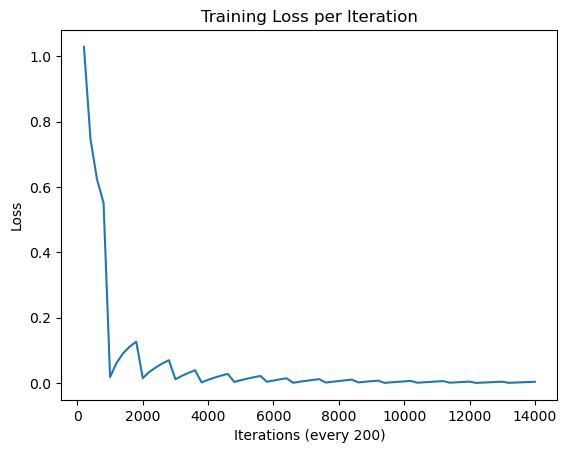

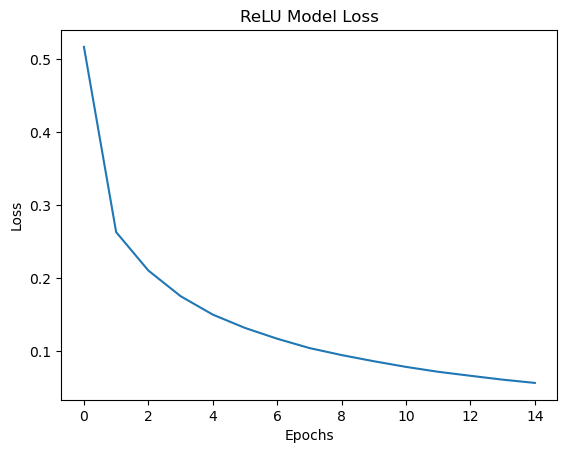

ReLU Accuracy: 0.9693
Confusion Matrix:
[[ 956    0    0    2    0   12    4    2    2    2]
 [   0 1121    2    2    0    3    3    1    3    0]
 [   5    0 1000    7    2    1    1    4   12    0]
 [   0    0    2  981    0   16    0    3    5    3]
 [   2    0    7    0  947    2    2    2    2   18]
 [   2    0    0    2    2  882    2    0    1    1]
 [   5    3    0    0    3   25  916    1    5    0]
 [   0    8   10    7    1    4    0  967    2   29]
 [   2    0    2    6    2   10    1    2  948    1]
 [   3    2    1    7    7    9    1    1    3  975]]



In [23]:
# Main function to train and evaluate models with different activations
def train_and_compare():
    input_size = 28 * 28
    hidden_sizes = [500, 250, 100]
    output_size = 10
    epochs = 15
    lr = 0.01
    plot_freq = 200

    train_loader, test_loader = load_data()

    # Model 1: Sigmoid
    nn_sigmoid = SimpleNN(input_size, hidden_sizes, output_size, act_sigmoid, deriv_sigmoid)
    print("Training Sigmoid Model")
    losses_sigmoid = train_nn(nn_sigmoid, train_loader, lr, epochs, plot_freq)
    acc_sigmoid, conf_sigmoid = eval_nn(nn_sigmoid, test_loader)
    plot_loss(losses_sigmoid, "Sigmoid Model Loss")
    print(f'Sigmoid Accuracy: {acc_sigmoid:.4f}\nConfusion Matrix:\n{conf_sigmoid}\n')

    # Model 2: Tanh
    nn_tanh = SimpleNN(input_size, hidden_sizes, output_size, act_tanh, deriv_tanh)
    print("Training Tanh Model")
    losses_tanh = train_nn(nn_tanh, train_loader, lr, epochs, plot_freq)
    acc_tanh, conf_tanh = eval_nn(nn_tanh, test_loader)
    plot_loss(losses_tanh, "Tanh Model Loss")
    print(f'Tanh Accuracy: {acc_tanh:.4f}\nConfusion Matrix:\n{conf_tanh}\n')

    # Model 3: ReLU
    nn_relu = SimpleNN(input_size, hidden_sizes, output_size, act_relu, deriv_relu)
    print("Training ReLU Model")
    losses_relu = train_nn(nn_relu, train_loader, lr, epochs, plot_freq)
    acc_relu, conf_relu = eval_nn(nn_relu, test_loader)
    plot_loss(losses_relu, "ReLU Model Loss")
    print(f'ReLU Accuracy: {acc_relu:.4f}\nConfusion Matrix:\n{conf_relu}\n')

# Run the comparison
train_and_compare()


### Define Custom MLP (Pytorch Definitions)

In [24]:
class SimpleNNPyTorch(nn.Module):
    def __init__(self):
        super(SimpleNNPyTorch, self).__init__()
        self.w1 = nn.Linear(28*28, 500)
        self.w2 = nn.Linear(500, 250)
        self.w3 = nn.Linear(250, 100)
        self.w4 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        a1 = F.relu(self.w1(x))
        a2 = F.relu(self.w2(a1))
        a3 = F.relu(self.w3(a2))
        a4 = F.log_softmax(self.w4(a3), dim=1)
        return a4

### Setup hypers and model summary

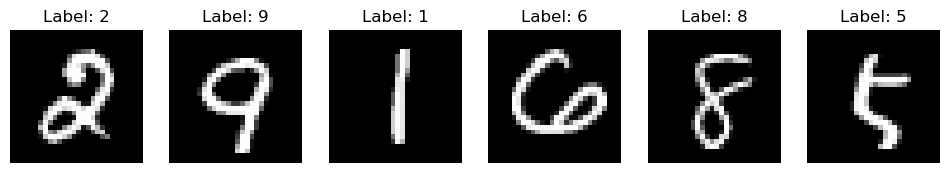

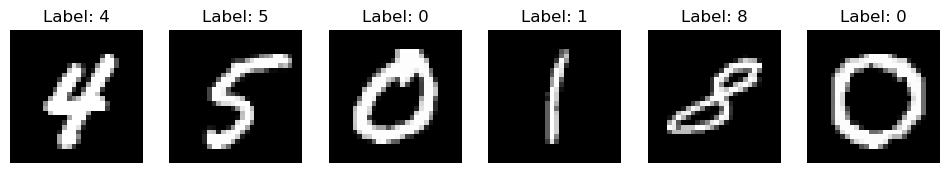

In [25]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 15

# DataLoader for MNIST Dataset
train_loader, test_loader = load_data(batch_size)

# Initialize the model, loss function, and optimizer
model = SimpleNNPyTorch()
cross_entropy_loss = nn.CrossEntropyLoss()


In [26]:
summary(model , input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 250]         125,250
            Linear-3                  [-1, 100]          25,100
            Linear-4                   [-1, 10]           1,010
Total params: 543,860
Trainable params: 543,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.07
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


### Training Pipeline

In [27]:
def train_mlp(model, train_loader, cross_entropy_loss, optimizer, epochs):
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            y_hat = model(data)
            loss = cross_entropy_loss(y_hat, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 200 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}')
        avg_epoch_loss = running_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Average Epoch Loss: {avg_epoch_loss:.4f}')
    return train_losses

### Evaluation and Plots

In [28]:
# Evaluate the model on test data
def evaluate_mlp(model, test_loader, cross_entropy_loss):
    model.eval()
    test_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            y_hat = model(data)
            test_loss += cross_entropy_loss(y_hat, target).item()
            pred = y_hat.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_true.extend(target.view_as(pred).cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Average Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    return avg_test_loss, accuracy, y_true, y_pred

In [29]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_loss(train_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Over Time")
    plt.show()

### SGD Optimizer

In [30]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
train_losses = train_mlp(model, train_loader, cross_entropy_loss, optimizer, epochs)

Epoch [1/15], Batch [0], Loss: 2.2937
Epoch [1/15], Batch [200], Loss: 2.1909
Epoch [1/15], Batch [400], Loss: 1.7474
Epoch [1/15], Batch [600], Loss: 0.9479
Epoch [1/15], Batch [800], Loss: 0.7025
Epoch [1/15], Average Epoch Loss: 1.4238
Epoch [2/15], Batch [0], Loss: 0.5369
Epoch [2/15], Batch [200], Loss: 0.3490
Epoch [2/15], Batch [400], Loss: 0.3744
Epoch [2/15], Batch [600], Loss: 0.5369
Epoch [2/15], Batch [800], Loss: 0.3459
Epoch [2/15], Average Epoch Loss: 0.4310
Epoch [3/15], Batch [0], Loss: 0.4051
Epoch [3/15], Batch [200], Loss: 0.5815
Epoch [3/15], Batch [400], Loss: 0.2758
Epoch [3/15], Batch [600], Loss: 0.3225
Epoch [3/15], Batch [800], Loss: 0.3370
Epoch [3/15], Average Epoch Loss: 0.3349
Epoch [4/15], Batch [0], Loss: 0.4065
Epoch [4/15], Batch [200], Loss: 0.3650
Epoch [4/15], Batch [400], Loss: 0.3427
Epoch [4/15], Batch [600], Loss: 0.6374
Epoch [4/15], Batch [800], Loss: 0.2708
Epoch [4/15], Average Epoch Loss: 0.2881
Epoch [5/15], Batch [0], Loss: 0.3515
Epoch 

In [32]:
avg_test_loss, accuracy, y_true, y_pred = evaluate_mlp(model, test_loader, cross_entropy_loss)

Average Test Loss: 0.0017, Accuracy: 96.73%


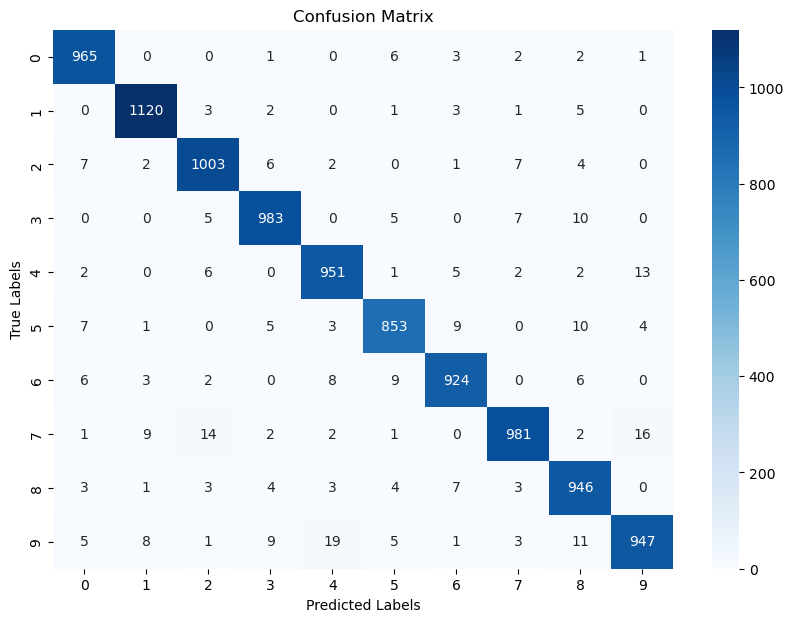

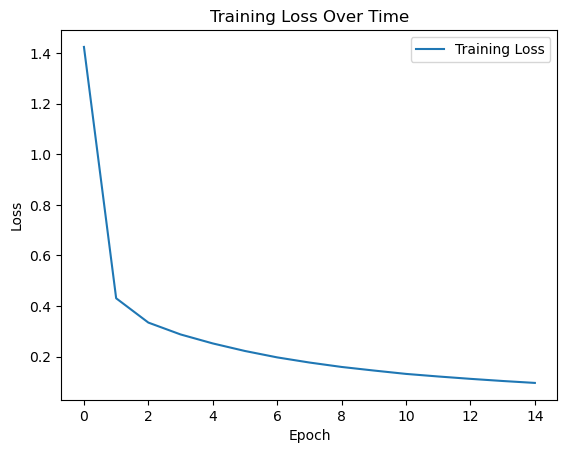

In [33]:
plot_confusion_matrix(y_true, y_pred)
plot_loss(train_losses)

### Adam Optmizer

In [34]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
train_losses = train_mlp(model, train_loader, cross_entropy_loss, optimizer, epochs)

Epoch [1/15], Batch [0], Loss: 0.0406
Epoch [1/15], Batch [200], Loss: 0.3545
Epoch [1/15], Batch [400], Loss: 0.5139
Epoch [1/15], Batch [600], Loss: 0.2896
Epoch [1/15], Batch [800], Loss: 0.3341
Epoch [1/15], Average Epoch Loss: 0.6613
Epoch [2/15], Batch [0], Loss: 0.2491
Epoch [2/15], Batch [200], Loss: 0.1694
Epoch [2/15], Batch [400], Loss: 0.1436
Epoch [2/15], Batch [600], Loss: 0.3409
Epoch [2/15], Batch [800], Loss: 0.2724
Epoch [2/15], Average Epoch Loss: 0.2567
Epoch [3/15], Batch [0], Loss: 0.2429
Epoch [3/15], Batch [200], Loss: 0.2743
Epoch [3/15], Batch [400], Loss: 0.0947
Epoch [3/15], Batch [600], Loss: 0.3412
Epoch [3/15], Batch [800], Loss: 0.3392
Epoch [3/15], Average Epoch Loss: 0.2344
Epoch [4/15], Batch [0], Loss: 0.2063
Epoch [4/15], Batch [200], Loss: 0.1732
Epoch [4/15], Batch [400], Loss: 0.5346
Epoch [4/15], Batch [600], Loss: 0.2451
Epoch [4/15], Batch [800], Loss: 0.3546
Epoch [4/15], Average Epoch Loss: 0.2400
Epoch [5/15], Batch [0], Loss: 0.5156
Epoch 

In [37]:
avg_test_loss, accuracy, y_true, y_pred = evaluate_mlp(model, test_loader, cross_entropy_loss)

Average Test Loss: 0.0036, Accuracy: 94.48%


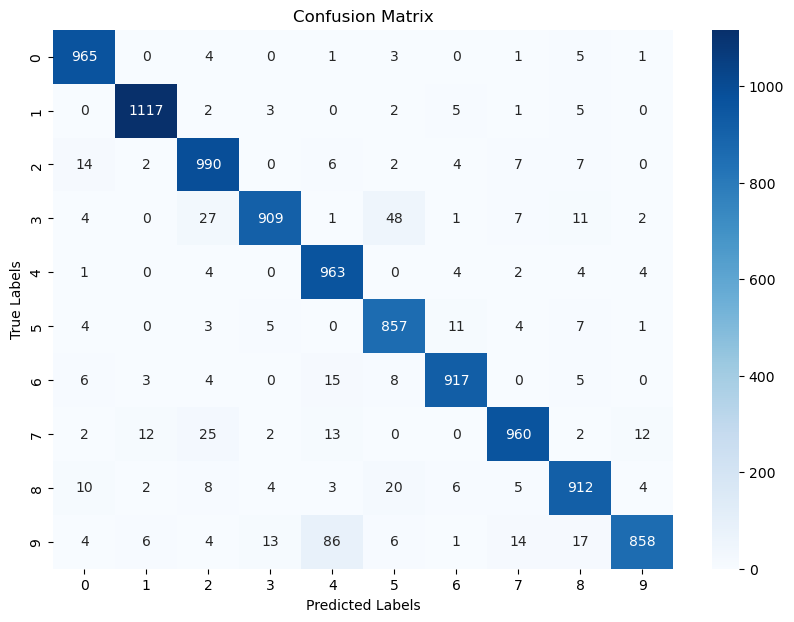

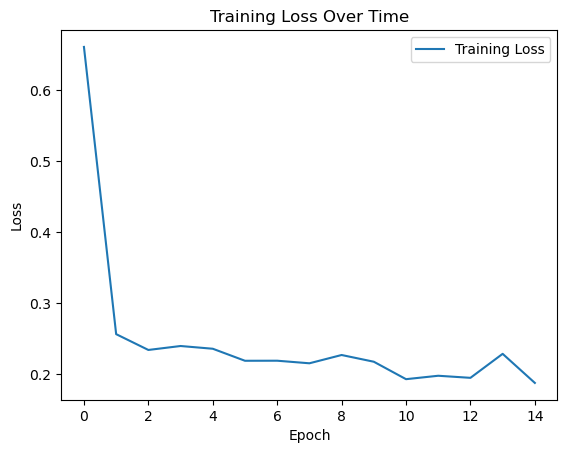

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_loss(train_losses)

### adam optimizer with L2 regularization

In [39]:
alpha = 1e-4 # 1e-5 to 1e-2

In [40]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)

In [42]:
train_losses = train_mlp(model, train_loader, cross_entropy_loss, optimizer, epochs)

Epoch [1/15], Batch [0], Loss: 0.1950
Epoch [1/15], Batch [200], Loss: 0.2345
Epoch [1/15], Batch [400], Loss: 0.1243
Epoch [1/15], Batch [600], Loss: 0.3235
Epoch [1/15], Batch [800], Loss: 0.1707
Epoch [1/15], Average Epoch Loss: 0.2187
Epoch [2/15], Batch [0], Loss: 0.4079
Epoch [2/15], Batch [200], Loss: 0.2915
Epoch [2/15], Batch [400], Loss: 0.1741
Epoch [2/15], Batch [600], Loss: 0.1327
Epoch [2/15], Batch [800], Loss: 0.1192
Epoch [2/15], Average Epoch Loss: 0.2142
Epoch [3/15], Batch [0], Loss: 0.1744
Epoch [3/15], Batch [200], Loss: 0.2065
Epoch [3/15], Batch [400], Loss: 0.1637
Epoch [3/15], Batch [600], Loss: 0.0292
Epoch [3/15], Batch [800], Loss: 0.2261
Epoch [3/15], Average Epoch Loss: 0.2345
Epoch [4/15], Batch [0], Loss: 0.0949
Epoch [4/15], Batch [200], Loss: 0.3374
Epoch [4/15], Batch [400], Loss: 0.2156
Epoch [4/15], Batch [600], Loss: 0.2845
Epoch [4/15], Batch [800], Loss: 0.2158
Epoch [4/15], Average Epoch Loss: 0.2184
Epoch [5/15], Batch [0], Loss: 0.2417
Epoch 

In [43]:
avg_test_loss, accuracy, y_true, y_pred = evaluate_mlp(model, test_loader, cross_entropy_loss)

Average Test Loss: 0.0033, Accuracy: 94.36%


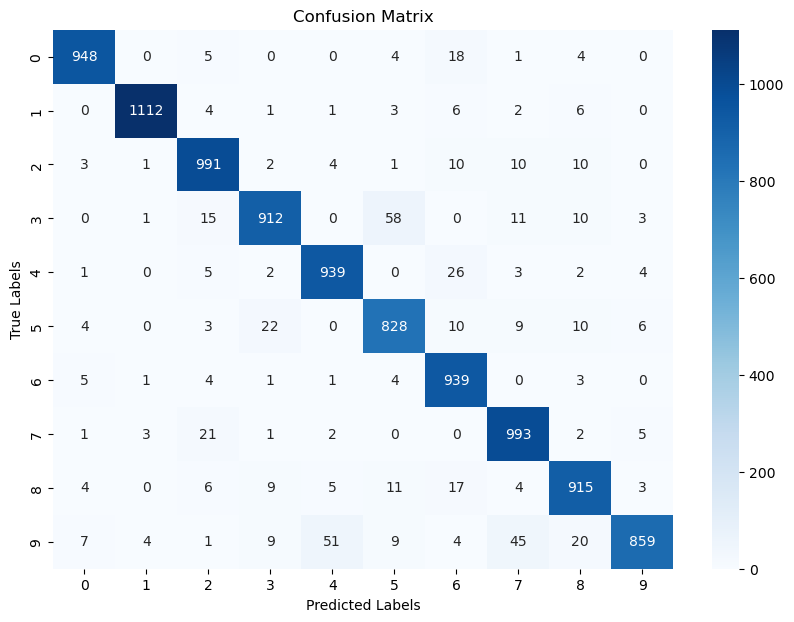

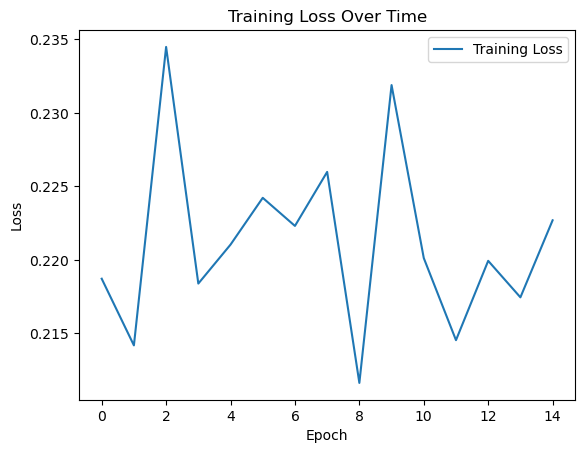

In [44]:
plot_confusion_matrix(y_true, y_pred)
plot_loss(train_losses)

###  <span style="color: yellow;">References</span>


1. https://padhai.onefourthlabs.in/
2. https://github.com/vishgoki/backprop-from-scratch-using-numpy/blob/main/backprop-manual.py
3. https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=32VHlw__V8s9
4. https://medium.com/@simple.schwarz/how-to-implement-a-feedforward-backpropagation-neural-network-in-python-with-mnist-dataset-a2e5888b3015
5. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
6. https://cs230.stanford.edu/section/4/
7. https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/